## Program 2.1 (SIR model) - original C code

In [1]:
%%writefile parameters.txt
Transmission_rate,_beta
			1.4247
Recovery_rate,_gamma
			0.14286
Initial_Susceptibles
			0.999999
Initial_Infecteds
			0.000001
Run_until_time
			70

Overwriting parameters.txt


In [2]:
%%writefile Program_2_1.c
/* ****************************************************************

This is the C version of program 2.1 from page 19 of
"Modeling Infectious Disease in humans and animals"
by Keeling & Rohani.

It is the simple SIR epidemic without births or deaths.

This code is written to be simple, transparent and readily compiled.
Far more elegant and efficient code can be written.

This code can be compiled using gnu or intel C compilers:
icc -o Program_2_1  Program_2_1.c  -lm
g++ -o Program_2_1  Program_2_1.c  -lm

If you have any difficulties, we suggest you set DEBUG to 1 or -1

******************************************************************/

#include <stdio.h>
#include <stdlib.h>
#include <math.h>
#include <string.h>

// Set DEBUG to 1 to output some debugging information
// Set DEBUG to -1 to output more debugging information
#define DEBUG 0

// Set up basic parameters
double beta=520.0/365.0;
double gamm=1.0/7.0;
double S0=1.0-1e-6;
double I0=1e-6;

double MaxTime=70;

// Set up variables and rates of change
double t,S,I,R,Pop[3];
double dPop[3];

// Initialise the equations and Runge-Kutta integration
void Diff(double Pop[3])
{
  // Set up temporary variables to make the equations look neater

  double tmpS, tmpI, tmpR;


  tmpS=Pop[0]; tmpI=Pop[1]; tmpR=Pop[2];

  /* The differential equations */

  dPop[0] = - beta*tmpS*tmpI;              // dS/dt
  dPop[1] = beta*tmpS*tmpI - gamm*tmpI;   // dI/dt
  dPop[2] = gamm*tmpI;                    // dR/dt

  return;
}


void Runge_Kutta(double);
void Read_in_parameters(FILE *);
void Perform_Checks();
void Output_Data(FILE *);


// The main program

int main(int argc, char** argv)
{
  char FileName[1000];
  double step, Every;
  FILE *in, *out;
   
  /* Find the given parameter  file name and open the file 
     otherwise use parameters set at top of program */
  if(argc>1)
    {
      strcpy(FileName, *(argv+1));  
      
      if((in = fopen(FileName,"r"))==NULL)
	{
	  printf("Cannot read file %s\n",FileName);
	  exit(1);
	}

      /* Read in the parameters */
      
      if(DEBUG) printf("\nReading parameters from file %s\n",FileName);

      Read_in_parameters(in);
	  
    }
  else
    {
      if(DEBUG) printf("\nUsing default parameters\n");
    }

  if(DEBUG) printf("beta=%g\ngamma=%g\nInitial S=%g\nInitial I=%g\nRuns until time %g\n\n",beta,gamm,S0,I0,MaxTime);
	

  /* Check all parameters are OK & set up intitial conditions */
  
  Perform_Checks();

  S=S0; I=I0; R=1-S-I;

  /* Find a suitable time-scale for outputs */

  step=0.01/((beta+gamm)*S0);
  
  Every=pow(10,floor(log10((1.0/((beta+gamm)*S0)))));
  while(MaxTime/Every>10000)
    {
      Every*=10.0;
    }
  if(DEBUG) printf("Using a time step of %g and outputing data every %g\n\n",step,Every);
   

  if((out = fopen("Program_2_1_c.out","w"))==NULL)
    {
      printf("Cannot open file Output to write data\n");
      exit(1);
    }

  /* The main iteration routine */

  t=0;

  Output_Data(out);

  

  do
    {
      Runge_Kutta(step);  t+=step;
      
      /* If time has moved on sufficiently, output the current data */
      if( floor(t/Every) > floor((t-step)/Every) )
	{
	  Output_Data(out);
	}
      else
	{
	  if(DEBUG<0)  Output_Data(stdout);
	}
      
    }
  while(t<MaxTime);


  Output_Data(out);

  fclose(out);
}






void Read_in_parameters(FILE *in)
{
  char str[200];
  fscanf(in,"%s",str);
  fscanf(in,"%lf",&beta);
  
  fscanf(in,"%s",str);
  fscanf(in,"%lf",&gamm);
  
  fscanf(in,"%s",str);
  fscanf(in,"%lf",&S0);
  
  fscanf(in,"%s",str);
  fscanf(in,"%lf",&I0);
  
  fscanf(in,"%s",str);
  fscanf(in,"%lf",&MaxTime);
  
  fclose(in);
}



void Perform_Checks()
{
  if(S0<=0) {printf("ERROR: Initial level of susceptibles (%g) is less than or equal to zero\n",S0); exit(1);}
  
  if(I0<=0) {printf("ERROR: Initial level of infecteds (%g) is less than or equal to zero\n",I0); exit(1);}
  
  if(beta<=0) {printf("ERROR: Transmission rate beta (%g) is less than or equal to zero\n",beta); exit(1);}
  
  if(gamm<=0) {printf("ERROR: Recovery rate gamma (%g) is less than or equal to zero\n",gamm); exit(1);}

  if(MaxTime<=0) {printf("ERROR: Maximum run time (%g) is less than or equal to zero\n",MaxTime); exit(1);}
  
  if(S0+I0>1) {printf("WARNING: Initial level of susceptibles+infecteds (%g+%g=%g) is greater than one\n",S0,I0,S0+I0);}

  if(beta<gamm) {printf("WARNING: Basic reproductive ratio (R_0=%g) is less than one\n",beta/gamm);}
}


void Output_Data(FILE *out)
{
  if(out!=stdout) fprintf(out,"%g\t%g\t%g\t%g\n",t,S,I,R);

  if(DEBUG) printf("%g\t%g\t%g\t%g\n",t,S,I,R);
}


void Runge_Kutta(double step)
{
  int i;
  double dPop1[3], dPop2[3], dPop3[3], dPop4[3];
  double tmpPop[3], initialPop[3];

  /* Integrates the equations one step, using Runge-Kutta 4
     Note: we work with arrays rather than variables to make the
     coding easier */

  initialPop[0]=S; initialPop[1]=I; initialPop[2]=R;

  Diff(initialPop);
  for(i=0;i<3;i++)
    {
      dPop1[i]=dPop[i];
      tmpPop[i]=initialPop[i]+step*dPop1[i]/2;
    }

  Diff(tmpPop);
  for(i=0;i<3;i++)
    {
      dPop2[i]=dPop[i];
      tmpPop[i]=initialPop[i]+step*dPop2[i]/2;  
    }

  Diff(tmpPop);
  for(i=0;i<3;i++)
    {
      dPop3[i]=dPop[i];
      tmpPop[i]=initialPop[i]+step*dPop3[i]; 
    }

  Diff(tmpPop);

  for(i=0;i<3;i++)
    {
      dPop4[i]=dPop[i];

      tmpPop[i]=initialPop[i]+(dPop1[i]/6 + dPop2[i]/3 + dPop3[i]/3 + dPop4[i]/6)*step;
    }


  S=tmpPop[0]; I=tmpPop[1]; R=tmpPop[2];

  return;
}

Overwriting Program_2_1.c


In [3]:
!gcc -O3 -o Program_2_1_c  Program_2_1.c  -lm

In [4]:
!./Program_2_1_c parameters.txt

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("ggplot")

In [6]:
sir_out = pd.read_csv("Program_2_1_c.out",sep="\t",header=None,names=["t","S","I","R"],index_col=False)

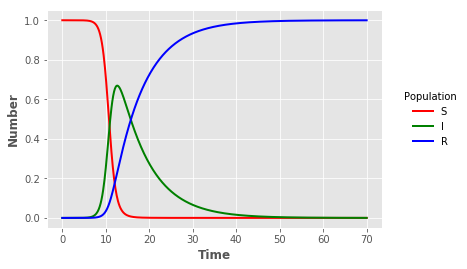

In [7]:
sline = plt.plot("t","S","",data=sir_out,color="red",linewidth=2)
iline = plt.plot("t","I","",data=sir_out,color="green",linewidth=2)
rline = plt.plot("t","R","",data=sir_out,color="blue",linewidth=2)
plt.xlabel("Time",fontweight="bold")
plt.ylabel("Number",fontweight="bold")
legend = plt.legend(title="Population",loc=5,bbox_to_anchor=(1.25,0.5))
frame = legend.get_frame()
frame.set_facecolor("white")
frame.set_linewidth(0)